In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools
import nltk
import keras

from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import Counter
from string import punctuation, digits
from nltk.corpus import stopwords

from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input
from keras.layers import Conv1D, MaxPooling1D, Concatenate, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers import LSTM, GRU, Bidirectional
from keras.layers import GlobalAveragePooling1D
from keras.preprocessing import sequence


Using TensorFlow backend.


## 1. 数据预处理

In [2]:
# 读取全集
newsgroups_all = fetch_20newsgroups(subset='all').data
print(type(newsgroups_all))
print(len(newsgroups_all))

<class 'list'>
18846


In [3]:
# 去除文档中的标点和数字，并全部转换成小写
all_texts = []
for text in newsgroups_all:
    all_texts.append(''.join([c for c in text.lower() if (c not in punctuation) and (c not in digits)]))
# print(all_texts[0])

In [4]:
# 将文档拆成单词
words = []
for text in all_texts:
    words += [word for word in text.split()]
print(len(words))

4990284


In [5]:
# 组成全集词汇表
counts = Counter(words)
counts.most_common()

[('the', 240506),
 ('to', 120304),
 ('of', 113840),
 ('a', 101126),
 ('and', 94986),
 ('in', 80337),
 ('is', 70061),
 ('i', 69387),
 ('that', 62564),
 ('it', 48290),
 ('for', 46412),
 ('you', 41114),
 ('from', 37198),
 ('on', 33028),
 ('this', 32733),
 ('be', 30746),
 ('not', 30324),
 ('are', 29969),
 ('have', 29962),
 ('with', 28624),
 ('as', 25734),
 ('or', 23745),
 ('was', 22739),
 ('if', 22495),
 ('but', 21821),
 ('subject', 20358),
 ('they', 20202),
 ('lines', 19652),
 ('organization', 18628),
 ('by', 18168),
 ('at', 17902),
 ('an', 16233),
 ('can', 15852),
 ('my', 15796),
 ('what', 15622),
 ('all', 15021),
 ('would', 14781),
 ('will', 14561),
 ('there', 14535),
 ('do', 14252),
 ('one', 14052),
 ('about', 13756),
 ('re', 13468),
 ('writes', 13330),
 ('we', 13029),
 ('he', 12368),
 ('so', 12315),
 ('your', 12283),
 ('has', 12177),
 ('no', 11972),
 ('any', 11543),
 ('article', 11457),
 ('me', 10990),
 ('some', 10908),
 ('who', 10603),
 ('its', 10172),
 ('which', 10170),
 ('were', 10

In [6]:
# 处理词汇表
# 从NLTK中引入停用词，从全集词汇表中删除
stoplist = stopwords.words('english')

# 从词汇表中删除计数少于10次，或者字母长度大于20的单词 like 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax'
vocab = {word: num for word, num in counts.items() if (word not in stoplist) and (num > 10) and (1 < len(word) < 20)}
print(len(vocab))
print(vocab)

20464
{'mamatha': 12, 'devineni': 12, 'ratnam': 15, 'mrandrewcmuedu': 12, 'subject': 20358, 'pens': 235, 'fans': 527, 'reactions': 92, 'organization': 18628, 'post': 1787, 'office': 814, 'carnegie': 282, 'mellon': 284, 'pittsburgh': 733, 'pa': 352, 'lines': 19652, 'nntppostinghost': 8065, 'poandrewcmuedu': 131, 'sure': 2751, 'pretty': 1227, 'confused': 166, 'lack': 470, 'kind': 1468, 'posts': 432, 'recent': 499, 'massacre': 199, 'devils': 197, 'actually': 2048, 'bit': 2698, 'puzzled': 21, 'relieved': 19, 'however': 2311, 'going': 3219, 'put': 2122, 'end': 1702, 'relief': 127, 'praise': 66, 'man': 1570, 'killing': 428, 'worse': 473, 'thought': 1616, 'jagr': 80, 'showed': 313, 'much': 4795, 'better': 2907, 'regular': 426, 'season': 780, 'stats': 318, 'also': 7232, 'lot': 2050, 'fo': 27, 'fun': 336, 'watch': 499, 'playoffs': 268, 'bowman': 70, 'let': 1800, 'next': 1729, 'couple': 941, 'games': 1351, 'since': 3488, 'beat': 315, 'jersey': 178, 'anyway': 1028, 'disappointed': 51, 'see': 5154

In [7]:
# 按照计数排序
vocab_list = sorted(vocab, key=vocab.get, reverse=True)

# 将单词映射到数字，从1开始
vocab_to_int = {word: i for i, word in enumerate(vocab_list, 1)}
print(vocab_to_int)

{'subject': 1, 'lines': 2, 'organization': 3, 'would': 4, 'one': 5, 'writes': 6, 'article': 7, 'dont': 8, 'like': 9, 'university': 10, 'people': 11, 'know': 12, 'get': 13, 'nntppostinghost': 14, 'think': 15, 'also': 16, 'use': 17, 'time': 18, 'new': 19, 'im': 20, 'good': 21, 'could': 22, 'well': 23, 'us': 24, 'may': 25, 'even': 26, 'see': 27, 'way': 28, 'much': 29, 'make': 30, 'many': 31, 'first': 32, 'two': 33, 'distribution': 34, 'say': 35, 'system': 36, 'right': 37, 'god': 38, 'want': 39, 'anyone': 40, 'world': 41, 'go': 42, 'used': 43, 'said': 44, 'need': 45, 'work': 46, 'really': 47, 'problem': 48, 'something': 49, 'please': 50, 'since': 51, 'computer': 52, 'believe': 53, 'still': 54, 'back': 55, 'ive': 56, 'going': 57, 'email': 58, 'find': 59, 'help': 60, 'information': 61, 'years': 62, 'file': 63, 'take': 64, 'using': 65, 'state': 66, 'might': 67, 'question': 68, 'usa': 69, 'point': 70, 'thanks': 71, 'last': 72, 'windows': 73, 'things': 74, 'better': 75, 'cant': 76, 'never': 77,

In [8]:
# 定义训练集和测试集的预处理函数
def pre_process_data(raw_data, seq_len=200):
    # raw data: 如newsgroups_train.data = fetch_20newsgroups(subset='train').data
    # seq_len: 文本序列长度
    
    # 将文档组成数字列表
    all_texts = []
    for text in raw_data:
        text = ''.join([c for c in text.lower() if c not in punctuation and c not in digits])
        text = [vocab_to_int[word] for word in text.split() if word in vocab_to_int]
        all_texts.append(text)
    
    # 把数字列表转换成200列的矩阵，不足200的序列前面补0，超过的取前200个数字
    features = np.zeros((len(all_texts), seq_len), dtype=int)
    for i, row in enumerate(all_texts):
        features[i, -len(row):] = np.array(row)[:seq_len]
    return features


def pre_process_targets(raw_target, classes=20):
    # 独热编码
    lb = preprocessing.LabelBinarizer()
    lb.fit(list(range(classes)))
    return lb.transform(raw_target)

In [9]:
train_features = pre_process_data(fetch_20newsgroups(subset='train').data)
train_features[:2]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [10]:
train_targets = pre_process_targets(fetch_20newsgroups(subset='train').target)
train_targets[:5]

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [11]:
test_x = pre_process_data(fetch_20newsgroups(subset='test').data)
test_y = pre_process_targets(fetch_20newsgroups(subset='test').target)
print(test_x.shape, test_y.shape)

(7532, 200) (7532, 20)


In [12]:
train_val = int(len(train_features) * 0.8) # split train set and validation set
train_x, val_x = train_features[:train_val], train_features[train_val:]
train_y, val_y = train_targets[:train_val], train_targets[train_val:]
print(train_x.shape, val_x.shape)

(9051, 200) (2263, 200)


In [13]:
sequence_length = 200 # 序列长度
num_classes = 20 # 类别数
vocab_size = len(vocab_to_int) + 1 # 词汇表大小
embedding_size = 128 # 词向量维度
filter_sizes = [3, 4, 5] # 卷积核的窗口长度
num_filters = 128 # 卷积核的数目
batch_size = 500
learning_rate = 0.001

## 2. TextCNN

In [14]:
# 模型结构：词嵌入-卷积池化*3-拼接-全连接-dropout-全连接
main_input = Input(shape=(sequence_length,), dtype='float64')
# 词嵌入（使用预训练的词向量）
embedder = Embedding(vocab_size, embedding_size, input_length=sequence_length)
embed = embedder(main_input)
# 词窗大小分别为3,4,5
cnn1 = Conv1D(num_filters, 3, padding='same', strides = 1, activation='relu')(embed)
cnn1 = MaxPooling1D(pool_size=4)(cnn1)
cnn2 = Conv1D(num_filters, 4, padding='same', strides = 1, activation='relu')(embed)
cnn2 = MaxPooling1D(pool_size=4)(cnn2)
cnn3 = Conv1D(num_filters, 5, padding='same', strides = 1, activation='relu')(embed)
cnn3 = MaxPooling1D(pool_size=4)(cnn3)
# 合并三个模型的输出向量
cnn = Concatenate(axis=-1)([cnn1,cnn2,cnn3])
flat = Flatten()(cnn)
drop = Dropout(0.2)(flat)
main_output = Dense(num_classes, activation='softmax')(drop)
model = Model(inputs = main_input, outputs = main_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

earlystop = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=0, verbose=0, mode='auto')]
model.fit(train_x, train_y, batch_size=500, epochs=10, 
          callbacks=earlystop, 
          validation_data=(val_x, val_y))

Train on 9051 samples, validate on 2263 samples
Epoch 1/10
9051/9051 [==============================] - 50s - loss: 2.9443 - acc: 0.0763 - val_loss: 2.8986 - val_acc: 0.1016
Epoch 2/10
9051/9051 [==============================] - 49s - loss: 2.7529 - acc: 0.1893 - val_loss: 2.6411 - val_acc: 0.1865
Epoch 3/10
9051/9051 [==============================] - 50s - loss: 2.1578 - acc: 0.4408 - val_loss: 1.8383 - val_acc: 0.4260
Epoch 4/10
9051/9051 [==============================] - 49s - loss: 1.2727 - acc: 0.6738 - val_loss: 1.1565 - val_acc: 0.6425
Epoch 5/10
9051/9051 [==============================] - 50s - loss: 0.6542 - acc: 0.8497 - val_loss: 0.7935 - val_acc: 0.7578
Epoch 6/10
9051/9051 [==============================] - 49s - loss: 0.3321 - acc: 0.9297 - val_loss: 0.6165 - val_acc: 0.8153
Epoch 7/10
9051/9051 [==============================] - 49s - loss: 0.1757 - acc: 0.9720 - val_loss: 0.5554 - val_acc: 0.8347
Epoch 8/10
9051/9051 [==============================] - 49s - loss: 0.

In [15]:
score, acc = model.evaluate(test_x, test_y, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

7532/7532 [==============================] - 11s    
Test score: 0.874639466729
Test accuracy: 0.755708972761


#################################################################################################################

## 3. TextCNN + BatchNormalization

### 在TextCNN基础上增加一层卷积，并使用BatchNormalization和dropout防止过拟合

In [16]:
# 词嵌入
main_input = Input(shape=(sequence_length,), dtype='float64')
embedder = Embedding(vocab_size, embedding_size, input_length=sequence_length)
embed = embedder(main_input)
# cnn1模块，kernel_size = 3
conv1_1 = Conv1D(256, 3, padding='same')(embed)
bn1_1 = BatchNormalization()(conv1_1)
relu1_1 = Activation('relu')(bn1_1)
conv1_2 = Conv1D(128, 3, padding='same')(relu1_1)
bn1_2 = BatchNormalization()(conv1_2)
relu1_2 = Activation('relu')(bn1_2)
cnn1 = MaxPooling1D(pool_size=4)(relu1_2)
# cnn2模块，kernel_size = 4
conv2_1 = Conv1D(256, 4, padding='same')(embed)
bn2_1 = BatchNormalization()(conv2_1)
relu2_1 = Activation('relu')(bn2_1)
conv2_2 = Conv1D(128, 4, padding='same')(relu2_1)
bn2_2 = BatchNormalization()(conv2_2)
relu2_2 = Activation('relu')(bn2_2)
cnn2 = MaxPooling1D(pool_size=4)(relu2_2)
# cnn3模块，kernel_size = 5
conv3_1 = Conv1D(256, 5, padding='same')(embed)
bn3_1 = BatchNormalization()(conv3_1)
relu3_1 = Activation('relu')(bn3_1)
conv3_2 = Conv1D(128, 5, padding='same')(relu3_1)
bn3_2 = BatchNormalization()(conv3_2)
relu3_2 = Activation('relu')(bn3_2)
cnn3 = MaxPooling1D(pool_size=4)(relu3_2)
# 拼接三个模块
cnn = Concatenate(axis=-1)([cnn1,cnn2,cnn3])
flat = Flatten()(cnn)
drop = Dropout(0.5)(flat)
fc = Dense(512)(drop)
bn = BatchNormalization()(fc)
main_output = Dense(num_classes, activation='sigmoid')(bn)
model = Model(inputs = main_input, outputs = main_output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# earlystop = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=0, verbose=0, mode='auto')]
model.fit(train_x, train_y, batch_size=500, epochs=5, validation_data=(val_x, val_y))

Train on 9051 samples, validate on 2263 samples
Epoch 1/5
9051/9051 [==============================] - 288s - loss: 3.1642 - acc: 0.0816 - val_loss: 3.1717 - val_acc: 0.0513
Epoch 2/5
9051/9051 [==============================] - 288s - loss: 2.5142 - acc: 0.3212 - val_loss: 3.8804 - val_acc: 0.0508
Epoch 3/5
9051/9051 [==============================] - 287s - loss: 1.9490 - acc: 0.5480 - val_loss: 6.0215 - val_acc: 0.0508
Epoch 4/5
9051/9051 [==============================] - 287s - loss: 1.5329 - acc: 0.5951 - val_loss: 7.8277 - val_acc: 0.0508
Epoch 5/5
9051/9051 [==============================] - 287s - loss: 1.2567 - acc: 0.6485 - val_loss: 8.5765 - val_acc: 0.0508


### 模型太过复杂，直接过拟合了

#################################################################################################################

## 4. TextRNN-LSTM

In [18]:
# 模型结构：词嵌入-LSTM-全连接
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=sequence_length))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# earlystop = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=0, verbose=0, mode='auto')]
model.fit(train_x, train_y, batch_size=500, epochs=30, validation_data=(val_x, val_y))

score, acc = model.evaluate(test_x, test_y, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train on 9051 samples, validate on 2263 samples
Epoch 1/30
9051/9051 [==============================] - 65s - loss: 2.9891 - acc: 0.0932 - val_loss: 2.9803 - val_acc: 0.1405
Epoch 2/30
9051/9051 [==============================] - 64s - loss: 2.9459 - acc: 0.1777 - val_loss: 2.9126 - val_acc: 0.2726
Epoch 3/30
9051/9051 [==============================] - 64s - loss: 2.7787 - acc: 0.2393 - val_loss: 2.5741 - val_acc: 0.2024
Epoch 4/30
9051/9051 [==============================] - 64s - loss: 2.4881 - acc: 0.2399 - val_loss: 2.3814 - val_acc: 0.2881
Epoch 5/30
9051/9051 [==============================] - 64s - loss: 2.2829 - acc: 0.3149 - val_loss: 2.1822 - val_acc: 0.3805
Epoch 6/30
9051/9051 [==============================] - 64s - loss: 2.0754 - acc: 0.4036 - val_loss: 2.0032 - val_acc: 0.4008
Epoch 7/30
9051/9051 [==============================] - 65s - loss: 1.8486 - acc: 0.4615 - val_loss: 1.8394 - val_acc: 0.4830
Epoch 8/30
9051/9051 [==============================] - 65s - loss: 1.

#################################################################################################################

## 4. TextRNN-2GRU

In [19]:
# 模型结构：词嵌入-双向GRU*2-全连接
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=sequence_length))
model.add(Bidirectional(GRU(128, dropout=0.5, recurrent_dropout=0.3, return_sequences=True)))
model.add(Bidirectional(GRU(128, dropout=0.5, recurrent_dropout=0.3)))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# earlystop = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=0, verbose=0, mode='auto')]
model.fit(train_x, train_y, batch_size=500, epochs=20, validation_data=(val_x, val_y))

score, acc = model.evaluate(test_x, test_y, batch_size=batch_size)
print('\nTesting...')
print('Test score:', score)
print('Test accuracy:', acc)

Train on 9051 samples, validate on 2263 samples
Epoch 1/20
9051/9051 [==============================] - 356s - loss: 2.9836 - acc: 0.0624 - val_loss: 2.9766 - val_acc: 0.0897
Epoch 2/20
9051/9051 [==============================] - 363s - loss: 2.9299 - acc: 0.1213 - val_loss: 2.8225 - val_acc: 0.1591
Epoch 3/20
9051/9051 [==============================] - 389s - loss: 2.5176 - acc: 0.1958 - val_loss: 2.3567 - val_acc: 0.2430
Epoch 4/20
9051/9051 [==============================] - 433s - loss: 2.0475 - acc: 0.3402 - val_loss: 1.9820 - val_acc: 0.3668
Epoch 5/20
9051/9051 [==============================] - 460s - loss: 1.5446 - acc: 0.4903 - val_loss: 1.7363 - val_acc: 0.4609
Epoch 6/20
9051/9051 [==============================] - 496s - loss: 1.1765 - acc: 0.6145 - val_loss: 1.6036 - val_acc: 0.5347
Epoch 7/20
9051/9051 [==============================] - 511s - loss: 0.8777 - acc: 0.7211 - val_loss: 1.4977 - val_acc: 0.5784
Epoch 8/20
9051/9051 [==============================] - 527s - 

#################################################################################################################

## 5. FastText

In [14]:
# 定义训练集和测试集的预处理函数
def pre_process_data_ft(raw_data, seq_len=200):
    # raw data: 如 newsgroups_train.data = fetch_20newsgroups(subset='train').data
    # seq_len: 文本序列长度
    
    # 将文档组成数字列表
    all_texts = []
    for text in raw_data:
        text = ''.join([c for c in text.lower() if c not in punctuation and c not in digits])
        text = [vocab_to_int[word] for word in text.split() if word in vocab_to_int]
        all_texts.append(text)
    
    return all_texts


def pre_process_targets(raw_target, classes=20):
    # 独热编码
    lb = preprocessing.LabelBinarizer()
    lb.fit(list(range(classes)))
    return lb.transform(raw_target)

In [15]:
# 创建 2-gram 子集并加入到词汇表中
def create_ngram_set(input_list, ngram_value=2):
    """
    创建n-grams集合, 例子：
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    {(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)}
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    将n-grams集合加入到词汇表token_indice中，并将其对应的值加入文本序列，2-gram例子：
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    添加3-gram例子：
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337], [1, 3, 7, 9, 2, 1337, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for i in range(len(new_list) - ngram_range + 1):
            for ngram_value in range(2, ngram_range + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [16]:
# 参数设置
ngram_range = 2
max_features = len(vocab_to_int) # 词汇表长度
maxlen = 200 # 序列长度
batch_size = 500
embedding_dims = 128
epochs = 5

In [17]:
train_features = pre_process_data_ft(fetch_20newsgroups(subset='train').data) # 预处理训练集特征
print(train_features[:2])

[[7293, 100, 1, 134, 14, 10104, 3, 10, 2384, 342, 1354, 2, 904, 40, 22, 8093, 134, 466, 117, 963, 2054, 134, 858, 1043, 618, 173, 15141, 3264, 47, 283, 1081, 564, 7946, 1451, 534, 472, 12, 40, 586, 150, 778, 2590, 62, 2368, 134, 89, 350, 567, 251, 185, 134, 50, 58, 71, 2099, 1031, 5816], [531, 6697, 1, 3320, 1069, 4949, 844, 166, 431, 844, 166, 3320, 1069, 997, 226, 563, 3, 10, 552, 2, 14, 1366, 83, 6476, 5134, 5055, 3320, 1069, 6495, 2336, 2361, 4949, 50, 195, 3555, 177, 9932, 2361, 2936, 479, 321, 18862, 947, 5180, 321, 582, 771, 8025, 1445, 15110, 2022, 2445, 477, 117, 1112, 273, 4672, 4307, 445, 4010, 183, 33, 292, 50, 582, 392, 740, 824, 184, 1069, 1494, 510, 2545, 4949, 71, 531, 6697]]


In [18]:
test_features = pre_process_data_ft(fetch_20newsgroups(subset='test').data) # 预处理测试集特征

print('Average train sequence length: {}'.format(np.mean(list(map(len, train_features)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, test_features)), dtype=int)))

Average train sequence length: 136
Average test sequence length: 132


In [19]:
print('Adding {}-gram features: '.format(ngram_range))
# 从训练集中创建n-gram集合
ngram_set = set()
for input_list in train_features:
    for i in range(2, ngram_range + 1):
        set_of_ngram = create_ngram_set(input_list, ngram_value=i)
        ngram_set.update(set_of_ngram)

print(len(ngram_set))

Adding 2-gram features: 
803430


In [20]:
# 在原始的词汇表基础上添加n-gram集合的映射
start_index = max_features + 1
token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
# print(token_indice)

In [21]:
indice_token = {token_indice[k]: k for k in token_indice}
print(len(indice_token))

803430


In [22]:
# 更新词汇表的长度
max_features = np.max(list(indice_token.keys())) + 1
max_features

823895

In [23]:
# 查看训练集和测试集中文本序列的平均长度
train_features = add_ngram(train_features, token_indice, ngram_range)
test_features = add_ngram(test_features, token_indice, ngram_range)
print('Average train sequence length: {}'.format(np.mean(list(map(len, train_features)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, test_features)), dtype=int)))

Average train sequence length: 271
Average test sequence length: 196


In [24]:
# 将训练集和测试集转换成等长的矩阵
maxlen = 200

print('Pad sequences (samples x time)')
train_x = sequence.pad_sequences(train_features, maxlen=maxlen)
test_x = sequence.pad_sequences(test_features, maxlen=maxlen)
print('x_train shape:', train_x.shape)
print('x_test shape:', test_x.shape)

Pad sequences (samples x time)
x_train shape: (11314, 200)
x_test shape: (7532, 200)


In [25]:
# 训练集和测试集特征
train_y = pre_process_targets(fetch_20newsgroups(subset='train').target)
test_y = pre_process_targets(fetch_20newsgroups(subset='test').target)
test_y.shape

(7532, 20)

In [26]:
# 将训练集拆分为训练和验证集 8 ：2

x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, shuffle=False)

In [27]:
print(x_train.shape, x_val.shape)

(9051, 200) (2263, 200)


In [55]:
# 查看并统计训练集，验证集和测试集中个类别分布
train_c = np.zeros(20, dtype=int)
val_c = np.zeros(20, dtype=int)
test_c = np.zeros(20, dtype=int)
for x in y_train:
    train_c += x

for x in y_val:
    val_c += x

for x in test_y:
    test_c += x

print(train_c)
print(val_c)
print(test_c)

[378 466 473 481 476 492 470 477 490 481 475 474 472 477 453 479 434 456
 354 293]
[102 118 118 109 102 101 115 117 108 116 125 121 119 117 140 120 112 108
 111  84]
[319 389 394 392 385 395 390 396 398 397 399 396 393 396 394 398 364 376
 310 251]


In [28]:
# 创建模型并训练 FastText
batch_size = 500
embedding_dims = 128
num_classes = 20
epochs = 30

print('Build model...')
model = Sequential()

# 根据词汇表随机初始化嵌入层
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

# 平均池化层
model.add(GlobalAveragePooling1D())

# 全连接层-分类器
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))

# score, acc = model.evaluate(test_x, test_y, batch_size=batch_size)
# print('Test score:', score)
# print('Test accuracy:', acc)

Build model...


D:\Anaconda\lib\site-packages\tensorflow\python\ops\gradients_impl.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 105458560 elements. This may consume a large amount of memory.
  "This may consume a large amount of memory." % num_elements)


Train on 9051 samples, validate on 2263 samples
Epoch 1/30
9051/9051 [==============================] - 48s - loss: 2.9845 - acc: 0.2507 - val_loss: 2.9701 - val_acc: 0.4202
Epoch 2/30
9051/9051 [==============================] - 45s - loss: 2.9384 - acc: 0.5878 - val_loss: 2.9382 - val_acc: 0.4865
Epoch 3/30
9051/9051 [==============================] - 45s - loss: 2.8800 - acc: 0.6252 - val_loss: 2.8952 - val_acc: 0.5122
Epoch 4/30
9051/9051 [==============================] - 45s - loss: 2.8020 - acc: 0.6333 - val_loss: 2.8411 - val_acc: 0.5347
Epoch 5/30
9051/9051 [==============================] - 45s - loss: 2.7024 - acc: 0.6598 - val_loss: 2.7735 - val_acc: 0.5709
Epoch 6/30
9051/9051 [==============================] - 45s - loss: 2.5791 - acc: 0.7010 - val_loss: 2.6922 - val_acc: 0.6054
Epoch 7/30
9051/9051 [==============================] - 45s - loss: 2.4315 - acc: 0.7523 - val_loss: 2.5967 - val_acc: 0.6487
Epoch 8/30
9051/9051 [==============================] - 45s - loss: 2.

In [30]:
# 模型测试评估
score, acc = model.evaluate(test_x, test_y, batch_size=batch_size)

print('\nTest score:', score)
print('Test accuracy:', acc)

7500/7532 [============================>.] - ETA: 0s
Test score: 1.26763671735
Test accuracy: 0.804301646372


In [31]:
# 第二次训练验证模型鲁棒性
# 创建模型并训练 FastText
batch_size = 500
embedding_dims = 128
num_classes = 20
epochs = 30

print('Build model...')
model = Sequential()

model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

model.add(GlobalAveragePooling1D())

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val))

print('\n##############')
score, acc = model.evaluate(test_x, test_y, batch_size=batch_size)
print('\nTest score:', score)
print('Test accuracy:', acc)

Build model...


D:\Anaconda\lib\site-packages\tensorflow\python\ops\gradients_impl.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 105458560 elements. This may consume a large amount of memory.
  "This may consume a large amount of memory." % num_elements)


Train on 9051 samples, validate on 2263 samples
Epoch 1/30
9051/9051 [==============================] - 48s - loss: 2.9843 - acc: 0.2702 - val_loss: 2.9694 - val_acc: 0.4481
Epoch 2/30
9051/9051 [==============================] - 45s - loss: 2.9364 - acc: 0.6240 - val_loss: 2.9361 - val_acc: 0.5219
Epoch 3/30
9051/9051 [==============================] - 45s - loss: 2.8765 - acc: 0.6582 - val_loss: 2.8926 - val_acc: 0.5502
Epoch 4/30
9051/9051 [==============================] - 45s - loss: 2.7978 - acc: 0.6827 - val_loss: 2.8376 - val_acc: 0.5705
Epoch 5/30
9051/9051 [==============================] - 45s - loss: 2.6975 - acc: 0.7037 - val_loss: 2.7706 - val_acc: 0.5961
Epoch 6/30
9051/9051 [==============================] - 45s - loss: 2.5742 - acc: 0.7267 - val_loss: 2.6899 - val_acc: 0.6067
Epoch 7/30
9051/9051 [==============================] - 45s - loss: 2.4274 - acc: 0.7637 - val_loss: 2.5947 - val_acc: 0.6438
Epoch 8/30
9051/9051 [==============================] - 45s - loss: 2.

In [32]:
y_pred = model.predict(test_x, batch_size=batch_size)
print(y_pred.shape)
print(y_pred[0])

(7532, 20)
[ 0.02391005  0.06869221  0.04458903  0.09018969  0.11340949  0.03717681
  0.05503929  0.08828909  0.04654048  0.06119573  0.04949447  0.02009286
  0.09507693  0.04339857  0.03845782  0.03529398  0.01690782  0.02543852
  0.01789591  0.02891124]


In [36]:
# 按照列 取最大值的索引
pred_y = np.argmax(y_pred,axis=1)
print(pred_y.shape)
print(pred_y[:20])

(7532,)
[ 4  1  0 17  0 13 15  2  5  1  2  1 17  8 15  3  2  1 12  7]


In [37]:
test_y1 = np.argmax(test_y,axis=1)
print(test_y1.shape)
print(test_y1[:20])

(7532,)
[ 7  5  0 17 19 13 15 15  5  1  2  5 17  8  0  2  4  1  6 16]


In [38]:
# 混淆矩阵
cnf_matrix = confusion_matrix(test_y1, pred_y)
type(cnf_matrix)

numpy.ndarray

In [39]:
cnf_matrix[:10, :10]

array([[223,   2,   0,   0,   2,   0,  11,   1,   0,   7],
       [  2, 297,   9,  11,  13,  23,  16,   0,   0,   5],
       [  0,  31, 284,  29,   6,   8,  13,   3,   2,   4],
       [  0,  21,  19, 291,  19,   2,  22,   0,   0,   1],
       [  0,   5,   6,  20, 314,   0,  26,   3,   1,   3],
       [  0,  51,  23,   8,   2, 298,  11,   1,   0,   0],
       [  0,   3,   1,  11,   4,   0, 361,   1,   2,   1],
       [  0,   3,   2,   3,   2,   0,  27, 342,   6,   2],
       [  0,   1,   0,   0,   1,   0,  11,  10, 371,   1],
       [  0,   1,   0,   0,   0,   0,  11,   0,   0, 373]], dtype=int64)

In [46]:
# 绘制混淆矩阵，归一化或者不归一
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


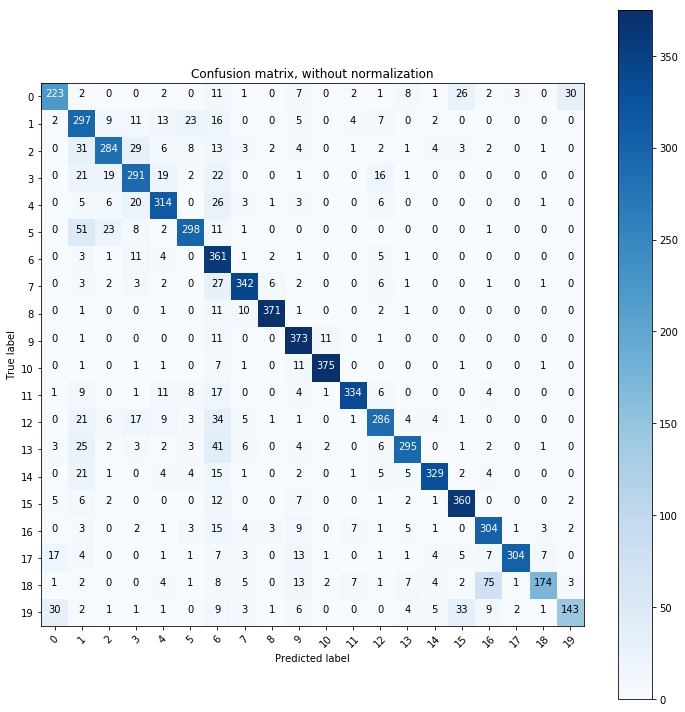

In [47]:
# 绘制非归一的混淆矩阵
np.set_printoptions(precision=2) # 保留2为小数

plt.figure()

plot_confusion_matrix(cnf_matrix, classes=range(20), title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix


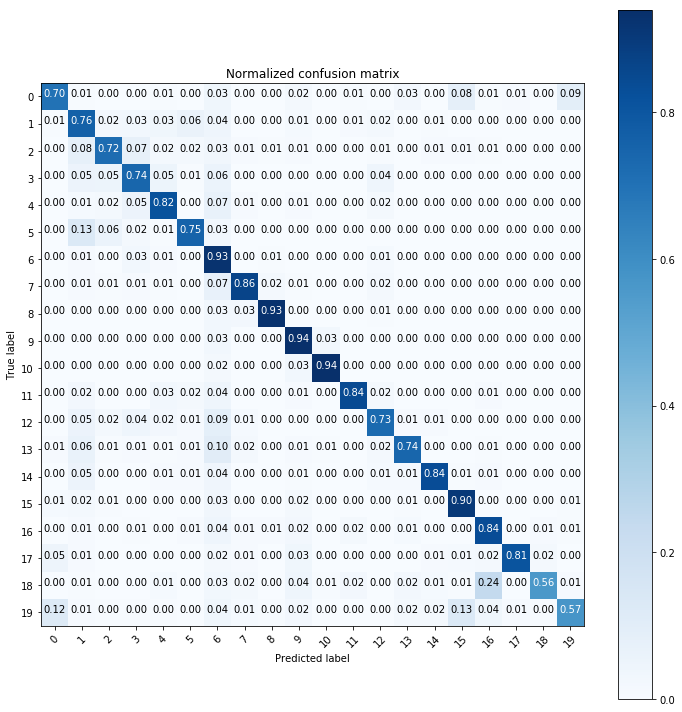

In [50]:
# 绘制非归一的混淆矩阵
plt.figure()

plot_confusion_matrix(cnf_matrix, classes=range(20), normalize=True, title='Normalized confusion matrix')
plt.show()

In [61]:
# 统计训练集中的数据量以及测试集中的分类准确率
for i in range(5):
    print(train_c[i]) # 训练集中各类别数据量大小
    print(cnf_matrix[i][i] / np.sum(cnf_matrix[i])) # 测试集中各类别分类准确率


378
0.699059561129
466
0.763496143959
473
0.720812182741
481
0.742346938776
476
0.815584415584


[378 466 473 481 476 492 470 477 490 481 475 474 472 477 453 479 434 456
 354 293] 
 [ 0.7   0.76  0.72  0.74  0.82  0.75  0.93  0.86  0.93  0.94  0.94  0.84
  0.73  0.74  0.84  0.9   0.84  0.81  0.56  0.57]


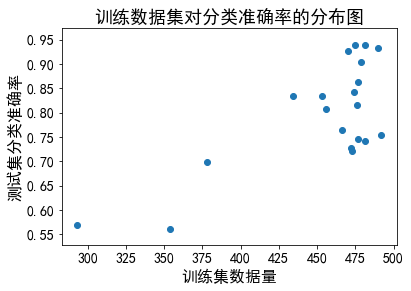

In [69]:
# 绘制 训练集中的数据量 - 测试集中的分类准确率的散点图
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签

x = np.zeros(20, dtype=int) # 记录数据量
y = np.zeros(20, dtype=float) # 记录的分类准确率
for i in range(20):
    x[i] = train_c[i]
    y[i] = cnf_matrix[i][i] / np.sum(cnf_matrix[i])

print(x, '\n' , y)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('训练集数据量', fontsize=16)
plt.ylabel('测试集分类准确率', fontsize=16)
plt.title('训练数据集对分类准确率的分布图', fontsize=18)
plt.scatter(x, y)  
plt.show()
